In [1]:
import scipy.io
import numpy as np
import pandas as pd
from savReaderWriter import SavReader

**Загружаем dataset**

Надо сделать как можно раньше, чтобы был полный список колонок
Процесс долгий, на инстансе amazon t3.xlarge (16 cpu, 16Gb mem, 32Gb swap, default ssd) занимает больше часа. При этом 
занимается 10Gb mem + 9.5Gb swap.

In [2]:
with SavReader('USER_RLMS-HSE_IND_1994_2019_v2_rus.sav', ioUtf8 = True) as reader:
    source_original_data = pd.DataFrame(reader.all(), columns = reader.header)
source_original_data.head()

,ID_W,IDIND,YEAR,REDID_I,ID_I,ID_H,ORIGSM,INWGT,REGION,PSU,...,S6,S7,S1.1_L,S1.2_L,S2_L,S3_L,S4_L,S5_L,S6_L,S7_L
0,5.0,1.0,1994.0,101.0,100101.0,1001.0,1.0,1.006194,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,2.0,1994.0,102.0,100102.0,1001.0,1.0,1.120193,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,3.0,1994.0,201.0,100201.0,1002.0,1.0,0.904263,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,4.0,1994.0,202.0,100202.0,1002.0,1.0,0.956155,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,5.0,1994.0,203.0,100203.0,1002.0,1.0,1.137990,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Для лучшей читаемости вынесем ключевые колонки в константы**

Так как кодификация столбцов не самая очевидная, некоторые используемые дальше столбцы закодируем более говорящими именами. Codebook взят отсюда: https://www.hse.ru/data/2020/08/30/1110539394/%D0%91%D0%94_2019_ind_codebook.pdf

In [103]:
class Columns:
    ALL = source_original_data.columns
    
    WAVE_ID = 'ID_W'
    PERSON_ID = 'IDIND'
    RESEARCH_YEAR = 'YEAR'
    INTERVIEW_YEAR = 'INT_Y'
    MARRIAGE_STATE = 'MARST'
    TOWN_STATUS = 'STATUS'
    REGION = 'REGION'
    PROFESSION_GROUP = 'OCCUP08'
    PROFESSION_CODE = 'J2COD08'
    PROFESSION_DIRECTION = 'J4.1'
    EDUCATION = 'DIPLOM'
    FIRST_FIME_FOR_PERSON = 'H4.1'  # 1 = yes, 2 = no
    GENDER = 'H5'
    YEAR_OF_BIRTH = 'H6'
    AGE = 'AGE'
    WORK_STATE = 'J1'  # 1 = working, 2-4 = vacantion, 5 = not working
    WORK_HAPINESS = 'J1.1.1'
    HAVE_PROBLEMS_WITH_MOVEMENT = 'M135' # 1 - ok, 2,3 - not ok
    
    TARGET = WORK_STATE  # take 1 & 5 only
    INTERESTING_POSSIBLE_TARGETS = [WORK_STATE, 'J1.1.1', 'J1.1.2', 'J1.1.3', 'J1.1.4', 'J1.1.5', 'J5A']
    HEALTH_CRITICAL_NEED_HELP = ['M23', 'M24.1', 'M24.2', 'M24.3', 'M24.4', 'M24.5']
    HEALTH_CRITICAL = [HAVE_PROBLEMS_WITH_MOVEMENT] + HEALTH_CRITICAL_NEED_HELP
    HEALTH_JUNK = {'M151', 'M20.9M'} # Don't use it as features
    HEALTH_DESCRIPTIONS = [
        column_name
        for column_name in ALL
            if column_name.startswith('M') and column_name not in {'M151', 'M20.9M', 'MARST'}
    ]
    
    SOCIAL = [AGE, TOWN_STATUS, REGION, MARRIAGE_STATE, EDUCATION, GENDER]

**Чистим данные**

1. Оставляем людей с возрастом на момент опроса 45-65 лет (см. `Columns.AGE`)
2. Оставляем людей из последних пяти фолн опроса (т.е. `Columns.INTERVIEW_YEAR >= 2010`)
3. Убираем из выборки людей, прикованных к кровати и имеющих проблемы с едой или одеванием (см. `Columns.HEALTH_CRITICAL`)
4. Убираем из выборки людей, находящихся в отпуске (см. `Columns.WORK_STATE`)

In [11]:
def filter_data(dataset, title, condition):
    result = dataset[condition(dataset)]
    num_filtered, num_rest = dataset.shape[0] - result.shape[0], result.shape[0]
    print('{title} condition filters {num_filtered} elements, {num_rest} is still there'.format(title=title, num_filtered=num_filtered, num_rest=num_rest))
    return result

In [104]:
filtered_data = source_original_data
filtered_data = filter_data(filtered_data, '1. AGE', lambda dataset: (45 <= dataset[Columns.AGE]) & (dataset[Columns.AGE] <= 62))
filtered_data = filter_data(filtered_data, '2. INTERVIEW_YEAR', lambda dataset: (dataset[Columns.INTERVIEW_YEAR] >= 2010))
filtered_data = filter_data(filtered_data, '3.1. HAVE_PROBLEMS_WITH_MOVEMENT', lambda dataset: (dataset[Columns.HAVE_PROBLEMS_WITH_MOVEMENT] != 2) & (dataset[Columns.HAVE_PROBLEMS_WITH_MOVEMENT] != 3))
for index, feature in enumerate(Columns.HEALTH_CRITICAL_NEED_HELP):
    filtered_data = filter_data(filtered_data, '3.{}. HEALTH_CRITICAL_NEED_HELP[{}]'.format(index + 1, index), lambda dataset: (dataset[feature] != 1))
filtered_data = filter_data(filtered_data, '4. WORK_STATE', lambda dataset: (dataset[Columns.WORK_STATE] == 1) | (dataset[Columns.WORK_STATE] == 5))

1. AGE condition filters 289421 elements, 82467 is still there
2. INTERVIEW_YEAR condition filters 36903 elements, 45564 is still there
3.1. HAVE_PROBLEMS_WITH_MOVEMENT condition filters 0 elements, 45564 is still there
3.1. HEALTH_CRITICAL_NEED_HELP[0] condition filters 0 elements, 45564 is still there
3.2. HEALTH_CRITICAL_NEED_HELP[1] condition filters 0 elements, 45564 is still there
3.3. HEALTH_CRITICAL_NEED_HELP[2] condition filters 0 elements, 45564 is still there
3.4. HEALTH_CRITICAL_NEED_HELP[3] condition filters 0 elements, 45564 is still there
3.5. HEALTH_CRITICAL_NEED_HELP[4] condition filters 0 elements, 45564 is still there
3.6. HEALTH_CRITICAL_NEED_HELP[5] condition filters 0 elements, 45564 is still there
4. WORK_STATE condition filters 178 elements, 45386 is still there


### Обучение и валидация

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

Определим функцию, которая обучает данный классификатор на заданных признаках и предсказывает другой заданный признак

1. Заполняем все невалидные значения (`NaN`, `null` etc.) с невалидным значением (`-1.0`)
2. Разбиваем случайным образом датасет на train и test подмножества в соотношении 2:1
3. Обучаем классификатор на train множестве
4. Считаем и возвращаем метрики качества на test-множестве:
    1. `feature_weights`: Веса признаков
    2. `precision`, `recall`, `f1`: Точность, полноту и f1-score полученного класификатора
    3. `confusion_matrix`: Матрица ошибок - какое количесто

In [127]:
from collections import namedtuple

ClassifierStats = namedtuple('ClassifierStats', ['classifier', 'feature_weights', 'precision', 'recall', 'f1', 'confusion_matrix'])

def print_classifier_stats(stats):
    print('Confusion matrix:')
    print(stats.confusion_matrix)
    print('Error fraction: {}'.format(1.0 * (stats.confusion_matrix[0, 1] + stats.confusion_matrix[1, 0]) / stats.confusion_matrix.sum()))
    print('f1 score: {}'.format(stats.f1))
    print('precision score: {}'.format(stats.precision))
    print('recall score: {}'.format(stats.recall))

In [113]:
def train_test(df, source_columns, target_column, classifier):
    shape = df.shape
    subdf = df[source_columns + [target_column]].fillna(value=-1.0)
    source_array = subdf[source_columns].to_numpy()
    target_array = subdf[target_column].to_numpy()
    source_train, source_test, target_train, target_test = train_test_split(source_array, target_array)
    
    classifier.fit(source_train, target_train)
    
    raw_feature_weights = classifier.feature_importances_ if hasattr(classifier, 'feature_importances_') else classifier.coef_
    feature_weights = sorted(list(zip(source_columns, raw_feature_weights)), key=lambda x: -x[1])

    predicted = classifier.predict(source_test)
    return ClassifierStats(
        classifier,
        feature_weights,
        precision_score(target_test == 1, predicted == 1),
        recall_score(target_test == 1, predicted == 1),
        f1_score(target_test == 1, predicted == 1),
        confusion_matrix(target_test, predicted)
    )

Для оценки качества выборки запустим обучение на отфильтрованном множестве. В качестве признаков будем использовать медицинские и социальные признаки (`Columns.HEALTH_DESCRIPTIONS`, `Columns.SOCIAL`), в качестве классификатора - лес случайных деревьев принятия решений (random forest)

In [128]:
total_stats = train_test(filtered_data, Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL, Columns.TARGET, RandomForestClassifier(n_estimators=100, n_jobs=-1))
print_classifier_stats(total_stats)

Confusion matrix:
[[6682  589]
 [1863 2213]]
Error fraction: 0.21609235921388914
f1 score: 0.8449671219018715
precision score: 0.781977764774722
recall score: 0.9189932608994636


Имеем точность 0.78 при полноте 0.91, что можно считать неплохим первым результатом

Посмотрим на распределение важности влияния признаков на результат. Вертикальной красной линией обозначается начало признаков со строго нулевым влиянием на результат

In [39]:
import matplotlib.pyplot as plt

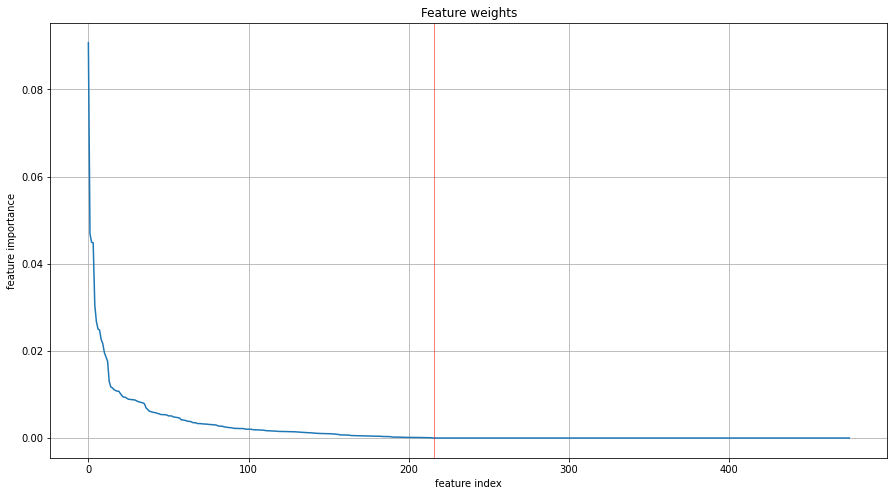

In [106]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(total_stats.feature_weights)), [x[1] for x in total_stats.feature_weights])
plt.axvline(sum(x[1] > 0.0 for x in total_stats.feature_weights), color='r', linewidth=0.5)
plt.title('Feature weights')
plt.xlabel('feature index')
plt.ylabel('feature importance')
plt.grid()
plt.show()

Рассмотрим первые 30 признаков, отсортированных по степени влияния на результат

In [107]:
for feature_name, feature_weight in total_stats.feature_weights[:30]:
    print('feature {:7} has weight {:.5f}'.format(feature_name, feature_weight))

feature AGE     has weight 0.09072
feature M1      has weight 0.04690
feature REGION  has weight 0.04491
feature M2      has weight 0.04481
feature DIPLOM  has weight 0.03056
feature STATUS  has weight 0.02675
feature M152    has weight 0.02504
feature M3      has weight 0.02474
feature M20.9Y  has weight 0.02262
feature MARST   has weight 0.02165
feature M20.8   has weight 0.01959
feature M20.7   has weight 0.01860
feature M2.1    has weight 0.01760
feature M72     has weight 0.01299
feature M170    has weight 0.01172
feature M58.1   has weight 0.01151
feature M149    has weight 0.01109
feature M75     has weight 0.01089
feature M20.61  has weight 0.01076
feature M114    has weight 0.01074
feature M64     has weight 0.01019
feature M131    has weight 0.00970
feature M84.5B  has weight 0.00939
feature M20.66  has weight 0.00936
feature M20.65  has weight 0.00914
feature M117.0  has weight 0.00891
feature M78     has weight 0.00886
feature M84.5D  has weight 0.00883
feature M81     has 

Расшифровка полученных признаков:

| Код признака | Расшифровка | Вес признака |
| --- | :- | --- |
| AGE     | Количество полных лет | 0.09072 |
| M1      | Сколько килограмм Вы весите? | 0.04690 |
| REGION  | Регион | 0.04491 |
| M2      | А какой у Вас рост в сантиметрах? | 0.04481 |
| DIPLOM  | ЗАКОНЧЕННОЕ ОБРАЗОВАНИЕ (ГРУППА) | 0.03056 |
| STATUS  | ТИП НАСЕЛЕННОГО ПУНКТА | 0.02675 |
| M152    | Удается ли Вам в целом питаться регулярно, не реже 3-х раз в день, изо дня в день? | 0.02504 |
| M3      | Скажите, пожалуйста, как Вы оцениваете Ваше здоровье? | 0.02474 |
| M20.9Y  | Когда Вам была назначена инвалидность? (ГОД) | 0.02262 |
| MARST   | СЕМЕЙНОЕ ПОЛОЖЕНИЕ В ТЕКУЩЕЙ ВОЛНЕ | 0.02165 |
| M20.8   | Какая группа инвалидности Вам назначена? | 0.01959 |
| M20.7   | Скажите, пожалуйста, назначена ли Вам какая-нибудь группа по инвалидности? | 0.01860 |
| M2.1    | Как изменился Ваш вес в течение последних 12-ти месяцев? | 0.01760 |
| M72     | Вспомните, пожалуйста, когда Вы начали курить? Сколько Вам тогда было лет? | 0.01299 |
| M170    | Скажите, пожалуйста, Вы счастливы? | 0.01172 |
| M58.1   | Говорил ли Вам врач, что у Вас повышенное артериальное давление? | 0.01151 |
| M149    | По какой цене Вы обычно покупаете пачку сигарет, папирос, табака, которые курите? | 0.01109 |
| M75     | Сколько примерно штук сигарет или папирос Вы обычно выкуриваете за день? | 0.01089 |
| M20.61  | Есть ли у Вас хронические заболевания сердца? | 0.01076 |
| M114    | Какой из вариантов описания лучше всего соответствует Вашим занятиям физкультурой? Пожалуйста, не учитывайте нагрузки на работе | 0.01074 |
| M64     | Вы пользуетесь очками или контактными линзами? | 0.01019 |
| M131    | В течение последних 12-ти месяцев у Вас были серьезные нервные расстройства, депрессии?  | 0.00970 |
| M84.5B  | Cколько грамм водки или других крепких напитков Вы обычно выпивали за день?  | 0.00939 |
| M20.66  | Есть ли у Вас хронические заболевания позвоночника? | 0.00936 |
| M20.65  | Есть ли у Вас хронические заболевания желудочно-кишечного тракта? | 0.00914 |
| M117.0  | За последние 30 дней Вы принимали какие-либо витамины, минеральные вещества, биологически активные добавки? | 0.00891 |
| M78     | Сколько лет тому назад Вы бросили курить? | 0.00886 |
| M84.5D  | Сколько дней в месяц пили водку или другие крепкие напитки? | 0.00883 |
| M81     | Как часто Вы употребляли алкогольные напитки в течение последних 30 дней?  | 0.00876 |
| M418    | Вы испытываете чувство одиночества? | 0.00874 |

По данной таблице видно, что:
- Наибольшее влияние имеет возраст. Этого логично ожидать, учитывая то, что в выборке рассматриваются широкий диапазон возрастов, с представиталями как допенсионного, так и пенсионного возраста
- Социальные факторы (регион проживания, уровень образования, семейное положение) влияют сильнее, чем медицинские. Такой эффект тоже легко объяснить гетерогенностью выборки, различиями в уровне безработицы в различных регионах, различиями в возможностях у людей с различным уровнем образования

Попробуем разбить выборку на несколько групп по признакам, имеющим наибольшее влияние:
- Возраст (AGE), и отдельно - принадлежность к пенсионному возрасту
- Регион проживания и статус населённого пункта (STATUS) и отдельно - проверим, насколько влияет проживание в Москве
- Законченное образование

### Возраст
Разобьём выборку на группы по пять лет и обучим независимую модель для каждой возрастной группы

In [129]:
AGE_SOURCE_COLUMNS = (Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL)
AGE_SOURCE_COLUMNS.remove(Columns.AGE)

AGE_STEP = 5
for age_min in range(45, 65, AGE_STEP):
    age_max = age_min + AGE_STEP
    
    aged_people = filter_data(filtered_data, 'AGE', lambda dataset: (age_min <= dataset[Columns.AGE]) & (dataset[Columns.AGE] < age_min + 5))
    aged_stats = train_test(aged_people, AGE_SOURCE_COLUMNS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    print('People with age {} - {}'.format(age_min, age_max - 1))
    print_classifier_stats(aged_stats)
    print('', end='\n\n')

AGE condition filters 33272 elements, 12114 is still there
People with age 45 - 49
Confusion matrix:
[[2399   38]
 [ 426  166]]
Error fraction: 0.15318586992406735
f1 score: 0.911820600532117
precision score: 0.8492035398230089
recall score: 0.9844070578580222


AGE condition filters 32729 elements, 12657 is still there
People with age 50 - 54
Confusion matrix:
[[2307   53]
 [ 553  252]]
Error fraction: 0.19146919431279621
f1 score: 0.8839080459770114
precision score: 0.8066433566433566
recall score: 0.9775423728813559


AGE condition filters 32124 elements, 13262 is still there
People with age 55 - 59
Confusion matrix:
[[1518  308]
 [ 547  943]]
Error fraction: 0.25784077201447525
f1 score: 0.7802621434078643
precision score: 0.7351089588377724
recall score: 0.8313253012048193


AGE condition filters 38033 elements, 7353 is still there
People with age 60 - 64
Confusion matrix:
[[ 227  438]
 [  79 1095]]
Error fraction: 0.2811310494834149
f1 score: 0.4675592173017508
precision score: 0

Видим, что после наступления пенсионного возраста результаты сильно снижаются, однако для возрастной страты 45-49 полученные результаты лучше, чем для общей выборки

### Разбивка по принадлежности к пенсионному возрасту

Рассмотрим разбивку на предмет принадлежности к пенсионному возрасту. Будем рассматривать только возраст до пенсионной реформы 2019 г., т.к. последняя волна опросов была в 2019, когда возраст ещё не повышался.
Итого считаем, что возраст выхода на пенсию 55 лет для женщин и 60 лет для мужчин

In [141]:
PENS_SOURCE_COLUMNS = (Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL)

for pension_descriptor in [(False, 'before pension'), (True, 'after pension')]:
    pension_value, description = pension_descriptor
    
    pens_people = filter_data(filtered_data, 'Pension', lambda dataset: (((55 <= dataset[Columns.AGE]) & (dataset[Columns.GENDER] == 2)) | ((60 <= dataset[Columns.AGE]) & (dataset[Columns.GENDER] == 1))) == pension_value)
    pens_stats = train_test(pens_people, PENS_SOURCE_COLUMNS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    print('People {}'.format(description))
    print_classifier_stats(pens_stats)
    print('', end='\n\n')

Pension condition filters 15256 elements, 30130 is still there
People before pension
Confusion matrix:
[[5498  143]
 [1220  672]]
Error fraction: 0.18093720961104473
f1 score: 0.8897159964398415
precision score: 0.8183983328371539
recall score: 0.9746498847722035


Pension condition filters 30130 elements, 15256 is still there
People after pension
Confusion matrix:
[[ 901  658]
 [ 436 1819]]
Error fraction: 0.28683796539066597
f1 score: 0.6222375690607735
precision score: 0.6738967838444279
recall score: 0.5779345734445157




### Законченное образование
Разобьём выборку по разным типам полученного образования и обучим независимые модели на остальных признаках

In [131]:
EDU_SOURCE_COLUMNS = (Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL)
EDU_SOURCE_COLUMNS.remove(Columns.EDUCATION)

EDU_VARIANTS = [
    (1, '0-6 classes'),
    (2, '7-8 classes'),
    (3, '7-8 classes + smth else'),
    (4, 'finished middle school'),
    (5, 'finished specialized middle school'),
    (6, 'finished high school'),
]
for edu_id, edu_name in EDU_VARIANTS:
    educated_people = filter_data(filtered_data, 'EDUCATION', lambda dataset: dataset[Columns.EDUCATION] == edu_id)
    educated_stats = train_test(educated_people, EDU_SOURCE_COLUMNS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    print('People with {} education (id = {})'.format(edu_name, edu_id))
    print_classifier_stats(educated_stats)
    print('', end='\n\n')

EDUCATION condition filters 45199 elements, 187 is still there
People with 0-6 classes education (id = 1)
Confusion matrix:
[[ 1  1]
 [ 0 45]]
Error fraction: 0.02127659574468085
f1 score: 0.6666666666666666
precision score: 1.0
recall score: 0.5


EDUCATION condition filters 43543 elements, 1843 is still there
People with 7-8 classes education (id = 2)
Confusion matrix:
[[173  45]
 [ 56 187]]
Error fraction: 0.21908893709327548
f1 score: 0.7740492170022373
precision score: 0.7554585152838428
recall score: 0.7935779816513762


EDUCATION condition filters 43025 elements, 2361 is still there
People with 7-8 classes + smth else education (id = 3)
Confusion matrix:
[[271  40]
 [103 177]]
Error fraction: 0.24196277495769883
f1 score: 0.7912408759124087
precision score: 0.7245989304812834
recall score: 0.8713826366559485


EDUCATION condition filters 27974 elements, 17412 is still there
People with finished middle school education (id = 4)
Confusion matrix:
[[2284  254]
 [ 726 1089]]
Error f

В данном случае недостаточно прецедентов для обучения на людях с низким уровнем образования (2361 человек с 7-8 классов и каким-то дополнительным), поэтому предлагается их не рассматривать. Тем не менее, для оконченных среднего, среднего специального и высшего уровня образования можно наблюдать неухудшение метрик по сравнению с основной выборкой

In [145]:
TOWN_STATUS_SOURCE_COLUMNS = (Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL)
TOWN_STATUS_SOURCE_COLUMNS.remove(Columns.TOWN_STATUS)

POSSIBLE_TOWN_STATUSES = [
    (1, 'State center'),
    (2, 'Town'),
    (3, 'Urban-type settlement'),
    (4, 'Vilage')
]

for (town_status_value, description) in POSSIBLE_TOWN_STATUSES:
    town_status_people = filter_data(filtered_data, 'TOWN_STATUS', lambda dataset: dataset[Columns.TOWN_STATUS] == town_status_value)
    town_status_stats = train_test(town_status_people, TOWN_STATUS_SOURCE_COLUMNS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    print('People living in {}'.format(description))
    print_classifier_stats(town_status_stats)
    print('', end='\n\n')

TOWN_STATUS condition filters 27852 elements, 17534 is still there
People living in State center
Confusion matrix:
[[2765  199]
 [ 753  667]]
Error fraction: 0.21715328467153286
f1 score: 0.8531317494600432
precision score: 0.7859579306424105
recall score: 0.9328609986504723


TOWN_STATUS condition filters 33261 elements, 12125 is still there
People living in Town
Confusion matrix:
[[1981  100]
 [ 494  457]]
Error fraction: 0.195910290237467
f1 score: 0.869622475856014
precision score: 0.8004040404040405
recall score: 0.9519461797212878


TOWN_STATUS condition filters 42222 elements, 3164 is still there
People living in Urban-type settlement
Confusion matrix:
[[440  52]
 [110 189]]
Error fraction: 0.20480404551201012
f1 score: 0.8445297504798465
precision score: 0.8
recall score: 0.8943089430894309


TOWN_STATUS condition filters 32823 elements, 12563 is still there
People living in Vilage
Confusion matrix:
[[1493  251]
 [ 411  986]]
Error fraction: 0.2107609041706463
f1 score: 0.81853

Аналогичным образом рассмотрим только жителей Москвы

In [144]:
MOSCOW_SOURCE_COLUMNS = (Columns.HEALTH_DESCRIPTIONS + Columns.SOCIAL)

moscow_people = filter_data(filtered_data, 'Is Moscow', lambda dataset: dataset[Columns.REGION] == 138)
moscow_stats = train_test(moscow_people, MOSCOW_SOURCE_COLUMNS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1))
print('People living in Moscow')
print_classifier_stats(moscow_stats)
print('', end='\n\n')

Is Moscow condition filters 41818 elements, 3568 is still there
People living in Moscow
Confusion matrix:
[[534  42]
 [151 165]]
Error fraction: 0.2163677130044843
f1 score: 0.8469468675654243
precision score: 0.7795620437956204
recall score: 0.9270833333333334




Как видим, результаты почти не отличаются от результата для всех городских жителей, то есть нет необходимости в дополнительной разбивке

### Только медицинские признаки, разбивка по пенсионному возрасту

Как видим по разбивкам выше, сильнее всего на разбивку влияет принадлежность к пенсионному возрасту. При этом выборка слишком маленькая, чтобы проверить все комбинации разбивок, предлагается рассматривать только разбивку по пенсионному возрасту.
Рассмотрим разбивку по пенсионному возрасту, но в качестве признаков будем использовать только поля, связанные со здоровьем, без социальных признаков

In [153]:
for pension_descriptor in [(False, 'before pension'), (True, 'after pension')]:
    pension_value, description = pension_descriptor
    
    pens_people = filter_data(filtered_data, 'Pension', lambda dataset: (((55 <= dataset[Columns.AGE]) & (dataset[Columns.GENDER] == 2)) | ((60 <= dataset[Columns.AGE]) & (dataset[Columns.GENDER] == 1))) == pension_value)
    pens_stats = train_test(pens_people, Columns.HEALTH_DESCRIPTIONS, Columns.TARGET, RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=1234))
    print('People {}'.format(description))
    print_classifier_stats(pens_stats)
    print('')
    for feature_name, feature_weight in pens_stats.feature_weights[:30]:
        print('feature {:7} has weight {:.5f}'.format(feature_name, feature_weight))
    print('', end='\n\n')

Pension condition filters 15256 elements, 30130 is still there
People before pension
Confusion matrix:
[[5435  193]
 [1291  614]]
Error fraction: 0.19699986725076332
f1 score: 0.8798769629269872
precision score: 0.8080582812964615
recall score: 0.9657071783937455

feature M1      has weight 0.07056
feature M2      has weight 0.06649
feature M3      has weight 0.03591
feature M20.9Y  has weight 0.03055
feature M152    has weight 0.02830
feature M20.8   has weight 0.02829
feature M20.7   has weight 0.02688
feature M2.1    has weight 0.02555
feature M72     has weight 0.02093
feature M149    has weight 0.01747
feature M75     has weight 0.01716
feature M170    has weight 0.01597
feature M58.1   has weight 0.01558
feature M64     has weight 0.01555
feature M84.5B  has weight 0.01401
feature M114    has weight 0.01371
feature M84.5D  has weight 0.01338
feature M131    has weight 0.01316
feature M20.614 has weight 0.01296
feature M81     has weight 0.01256
feature M20.66  has weight 0.01227


Расшифровка полученных признаков для допенсионного возраста:

| Код признака | Расшифровка | Вес признака |
| --- | :- | --- |
| M1      | Сколько килограмм Вы весите? | 0.07142 |
| M2      | А какой у Вас рост в сантиметрах?  | 0.06718 |
| M3      | Скажите, пожалуйста, как Вы оцениваете Ваше здоровье? | 0.03673 |
| M20.9Y  | Когда Вам была назначена инвалидность? (ГОД) | 0.02988 |
| M152    | Удается ли Вам в целом питаться регулярно, не реже 3-х раз в день, изо дня в день? | 0.02843 |
| M20.8   | Какая группа инвалидности Вам назначена? | 0.02723 |
| M20.7   | Скажите, пожалуйста, назначена ли Вам какая-нибудь группа по инвалидности? | 0.02592 |
| M2.1    | Как изменился Ваш вес в течение последних 12-ти месяцев?  | 0.02535 |
| M72     | Вспомните, пожалуйста, когда Вы начали курить? Сколько Вам тогда было лет? | 0.02120 |
| M149    | По какой цене Вы обычно покупаете пачку сигарет, папирос, табака, которые курите? | 0.01776 |
| M75     | Сколько примерно штук сигарет или папирос Вы обычно выкуриваете за день?  | 0.01761 |
| M170    | Скажите, пожалуйста, Вы счастливы? | 0.01603 |
| M64     | Вы пользуетесь очками или контактными линзами? | 0.01588 |
| M58.1   | Говорил ли Вам врач, что у Вас повышенное артериальное давление? | 0.01579 |
| M84.5B  | Cколько грамм водки или других крепких напитков Вы обычно выпивали за день? | 0.01372 |
| M131    | В течение последних 12-ти месяцев у Вас были серьезные нервные расстройства, депрессии? | 0.01348 |
| M114    | Какой из вариантов описания лучше всего соответствует Вашим занятиям физкультурой? Пожалуйста, не учитывайте нагрузки на работе | 0.01336 |
| M20.614 | Есть ли у Вас хронические гинекологические заболевания? | 0.01278 |
| M84.5D  | Сколько дней в месяц пили водку или другие крепкие напитки? | 0.01271 |
| M20.66  | Есть ли у Вас хронические заболевания позвоночника? | 0.01260 |
| M78     | Сколько лет тому назад Вы бросили курить? | 0.01249 |
| M81     | Как часто Вы употребляли алкогольные напитки в течение последних 30 дней? | 0.01229 |
| M150    | Что Вы предпримите, если цены на сигареты, папиросы, табак, которые Вы обычно курите, вырастут в два раза? | 0.01191 |
| M79     | Вспомните, пожалуйста, когда Вы начали курить? Сколько Вам тогда было лет? | 0.01151 |
| M418    | Вы испытываете чувство одиночества? | 0.01108 |
| M20.65  | Есть ли у Вас хронические заболевания желудочно-кишечного тракта?  | 0.01104 |
| M117.0  | За последние 30 дней Вы принимали какие-либо витамины, минеральные вещества, биологически активные добавки? | 0.01029 |
| M20.61  | Есть ли у Вас хронические заболевания сердца? | 0.00992 |
| M20.69  | Есть ли у Вас гипертоническая болезнь, повышенное артериальное давление? | 0.00956 |
| M20.610 | Есть ли у Вас хронические заболевания суставов? | 0.00945 |

Аналогичная таблица важности признаков для людей пенсионного возраста:

| Код признака | Расшифровка | Вес признака |
| --- | :- | --- |
| M1      | Сколько килограмм Вы весите? | 0.08062 |
| M2      | А какой у Вас рост в сантиметрах? | 0.07263 |
| M152    | Удается ли Вам в целом питаться регулярно, не реже 3-х раз в день, изо дня в день? | 0.03274 |
| M2.1    | Как изменился Ваш вес в течение последних 12-ти месяцев? | 0.02853 |
| M3      | Скажите, пожалуйста, как Вы оцениваете Ваше здоровье? | 0.02694 |
| M114    | Какой из вариантов описания лучше всего соответствует Вашим занятиям физкультурой? Пожалуйста, не учитывайте нагрузки на работе | 0.01805 |
| M170    | Скажите, пожалуйста, Вы счастливы? | 0.01748 |
| M58.1   | Говорил ли Вам врач, что у Вас повышенное артериальное давление? | 0.01564 |
| M20.65  | Есть ли у Вас хронические заболевания желудочно-кишечного тракта? | 0.01539 |
| M20.66  | Есть ли у Вас хронические заболевания позвоночника? | 0.01511 |
| M20.61  | Есть ли у Вас хронические заболевания сердца? | 0.01489 |
| M117.0  | За последние 30 дней Вы принимали какие-либо витамины, минеральные вещества, биологически активные добавки? | 0.01489 |
| M20.9Y  | Когда Вам была назначена инвалидность? (ГОД) | 0.01426 |
| M131    | В течение последних 12-ти месяцев у Вас были серьезные нервные расстройства, депрессии? | 0.01406 |
| M20.610 | Есть ли у Вас хронические заболевания суставов? | 0.01362 |
| M418    | Вы испытываете чувство одиночества? | 0.01361 |
| M20.614 | Есть ли у Вас хронические гинекологические заболевания? | 0.01300 |
| M20.69  | Есть ли у Вас гипертоническая болезнь, повышенное артериальное давление? | 0.01258 |
| M72     | Вспомните, пожалуйста, когда Вы начали курить? Сколько Вам тогда было лет? | 0.01257 |
| M20.8   | Какая группа инвалидности Вам назначена? | 0.01226 |
| M64     | Вы пользуетесь очками или контактными линзами? | 0.01222 |
| M20.7   | Скажите, пожалуйста, назначена ли Вам какая-нибудь группа по инвалидности? | 0.01073 |
| M117.1  | За последние 12 месяцев Вы сидели на какой-нибудь диете? Диетой мы считаем любое изменение в Вашей обычной еде именно для того, чтобы сбросить вес, похудеть, сохранить или улучшить здоровье | 0.01061 |
| M20.616 | Есть ли у Вас варикозное расширение вен?  | 0.01017 |
| M20.63  | Есть ли у Вас хронические заболевания печени?  | 0.01017 |
| M81     | Как часто Вы употребляли алкогольные напитки в течение последних 30 дней?  | 0.01012 |
| M84.5B  | Cколько грамм водки или других крепких напитков Вы обычно выпивали за день? | 0.01009 |
| M75     | Сколько примерно штук сигарет или папирос Вы обычно выкуриваете за день? | 0.00991 |
| M78     | Сколько лет тому назад Вы бросили курить? | 0.00978 |
| M20.613 | Есть ли у Вас хронические заболевания глаз? | 0.00969 |